## Feature Selection with LASSO & VIF

Michael Massone & Nelson Farrell  
Final Project Phase 3  
DS 5220  
Steve Morin PhD.  
12-04-24
___

### Import Packages

In [28]:
import sys
import time
from pathlib import Path
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

### Set up for imports of ```.py``` modules by adding path to ```sys.path```

In [29]:
path = Path.cwd()
mods_dir = "/modules"
path_to_project_directory = path.parent
sys.path.insert(1, str(path_to_project_directory))
sys.path.insert(1, str(path_to_project_directory) + mods_dir)
print(f"The working directory has been set to: {str(path_to_project_directory)}")

The working directory has been set to: /Users/nelsonfarrell/Documents/Northeastern/5220/final_project


### Import Modules

In [30]:

import utils.assign_3_utils as assign_3_utils
import utils.multi_colinearity_utils as mc_utils
import utils.regression_utils as reg_utils
import utils.sml_utils as sml_utils
import utils.bin_class_utils as class_utils
import utils.glue_old_to_new as gotn
import utils.assign_and_lab_utils as al_utils
import utils.classification_utils as class_utils_2
import utils.reg_model_selection_utils as reg_ms_utils

### Helper Functions

In [4]:
# None

### Parameters

In [5]:
# Set path to data
path_to_data = "../data/filtered_datasets/data_set_D_B.csv"

# Step 1 parameters - check for missingness in target vector
target_attr = 'Segmentation'

# Step 2 parameters - train/test split
test_size = 0.20
train_test_split_random_state = 42

# Step 3 parameters - train/validation split

# Step 5 parameters - identify attributes with missingness above threshold
missingness_threshold = 0.20

# Step 9 parameters - build a composite estimator
target_encoder_random_state = 42

# model selection parameters
num_std = 1.0

model_type = 'LogisticRegressionCV'  # model specific cv from sklearn
cv_folds = 5  # number of folds for model specific cv
scoring='neg_log_loss'
max_iter=100
class_weight=None  # changing this could impact regularization

penalty='l1'  # Cs describes the inverse of regularization strength

if penalty == 'l1':
    
    l1_ratio_list = None
    solver = 'saga'  # solver can be {‘liblinear’, ‘saga’}
    cap_c_s = np.logspace(-4, 1, 50)  # l1 - Cs describes the inverse of regularization strength
    
elif penalty == 'l2':

    l1_ratio_list = None
    solver = 'saga'  # solver can be {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
    cap_c_s = np.logspace(-7, 1, 50)  # l2 - Cs describes the inverse of regularization strength
    
elif penalty == 'elasticnet':
    
    l1_ratio_list = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]  # values of l1 for ElasticNetCV to search over
    solver = 'saga'  # solver can be {‘saga’}
    
else:
    
    sys.exit(f'penalty {penalty} is unrecognized')

# understand nature of synthetic attributes
col_idx_shuffle_map = False

# check out attribute multi colinearity
check_out_multi_colinearity = False

### Set up to time script run time

In [6]:
start = time.time()

### Read in the data and get the size of the data

In [7]:
df = pd.read_csv(path_to_data)
print(df.shape)
df.head()

(4126, 12)


,Unnamed: 0,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
2,3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
3,7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
4,8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D


### Out of pipeline preprocessing

### These operations cannot be completed in the scikit-learn pipeline.

### They should be identified and passed on the the data engineer as tasks conducted during extract/transform/load (ETL) if the model goes to production.

## 1. check for missingness in target vector

In [8]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(4126, 12)
(4126, 12)


## 2. label binarize

In [9]:
if pd.api.types.infer_dtype(df[target_attr]) == 'string':
    df, le_name_mapping = class_utils.label_binarize_binary(df, target_attr, print_results=True)
else:
    print(f'df[target_attr] is not a string attribute')


df[target_attr] is a string attribute

df.loc[0:5, target_attr]:
0    D
1    B
2    B
3    D
4    D
Name: Segmentation, dtype: object

Segmentation
D    0.549685
B    0.450315
Name: proportion, dtype: float64

label encode df[target_attr]

after label encoding df[target_attr]

Segmentation
0.0    0.549685
1.0    0.450315
Name: proportion, dtype: float64

df.loc[0:5, target_attr]:
0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: Segmentation, dtype: float64

lb_name_mapping: {0: 'D', 1: 'B'}


## 3. train/test split

In [10]:
train_cap_x_df, train_y_df = sml_utils.perform_the_train_test_split(df, test_size, train_test_split_random_state, val=False)

*************************

df.shape:
(4126, 12)

*************************

train_df.csv:
(3300, 11) (3300, 1)

*************************

test_df.csv
(826, 11) (826, 1)


## 4. train/validation split

### We will use the k-fold cross validation to select a model - no validation set is required.

### Check out the attribute types

In [11]:
train_cap_x_df.dtypes

Unnamed: 0           int64
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
dtype: object

## 5. identify attributes with  missingness above threshold

In [12]:
return_dict = sml_utils.get_missingness(train_cap_x_df, missingness_threshold)
missingness_drop_list = return_dict['missingness_drop_list']

Unnamed: 0 missingness = 0.0
ID missingness = 0.0
Gender missingness = 0.0
Ever_Married missingness = 0.021212121212121213
Age missingness = 0.0
Graduated missingness = 0.010606060606060607
Profession missingness = 0.018484848484848486
Work_Experience missingness = 0.11696969696969697
Spending_Score missingness = 0.0
Family_Size missingness = 0.04606060606060606
Var_1 missingness = 0.00909090909090909

missingness_drop_list:
[]


## 6. identify non machine learning attributes

In [13]:
sml_utils.check_for_complete_unique_attrs(train_cap_x_df)

the data frame has 3300 rows

Unnamed: 0 has 3300 unique values and is dtype int64 examine more closely
ID has 3300 unique values and is dtype int64 examine more closely
Gender has 2 unique values and is dtype object 
Ever_Married has 2 unique values and is dtype object 
Age has 67 unique values and is dtype int64 
Graduated has 2 unique values and is dtype object 
Profession has 9 unique values and is dtype object 
Work_Experience has 15 unique values and is dtype float64 
Spending_Score has 3 unique values and is dtype object 
Family_Size has 9 unique values and is dtype float64 
Var_1 has 7 unique values and is dtype object 


['Unnamed: 0', 'ID']

In [14]:
non_ml_attr_list = ['Unnamed: 0', "ID"]

## 7. identify attributes to exclude from machine learning

In [15]:
train_cap_x_df.columns

Index(['Unnamed: 0', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [16]:
ml_attr_drop_list = ["Ever_Married"] # ["Work_Experience", "Var_1", "Gender", "Family_Size"]

## 8. establish machine learning attribute configuration

In [17]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

['Unnamed: 0', 'ID', 'Ever_Married']

In [18]:
train_cap_x_df.columns

Index(['Unnamed: 0', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [19]:
train_cap_x_df.dtypes

Unnamed: 0           int64
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
dtype: object

In [20]:
# identify the remaining numerical attributes to be used in machine learning and enter them into the 
# numerical_attr list below.
numerical_attr = ["Age", "Work_Experience", "Family_Size"]

# identify the remaining nominal attributes to be used in machine learning and enter them into the 
# nominal_attr list below.

nominal_attr = ["Graduated", "Profession", "Spending_Score", "Gender", "Var_1"]

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))  # got them all?

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {nominal_attr}')

print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: ['Unnamed: 0', 'ID', 'Ever_Married']

numerical_attr: ['Age', 'Work_Experience', 'Family_Size']
nominal_attr: ['Graduated', 'Profession', 'Spending_Score', 'Gender', 'Var_1']

number of machine learning attributes: 8

numerical_attr and nominal_attr: ['Age', 'Work_Experience', 'Family_Size', 'Graduated', 'Profession', 'Spending_Score', 'Gender', 'Var_1']


## 9. assess target attribute imbalance

In [21]:
train_y_df[target_attr].unique().tolist()

[1.0, 0.0]

In [22]:
train_y_df[target_attr].value_counts(normalize=True)

Segmentation
0.0    0.554242
1.0    0.445758
Name: proportion, dtype: float64

### Deviate from binary classification flow - we are working to find a less complex model by variable selection

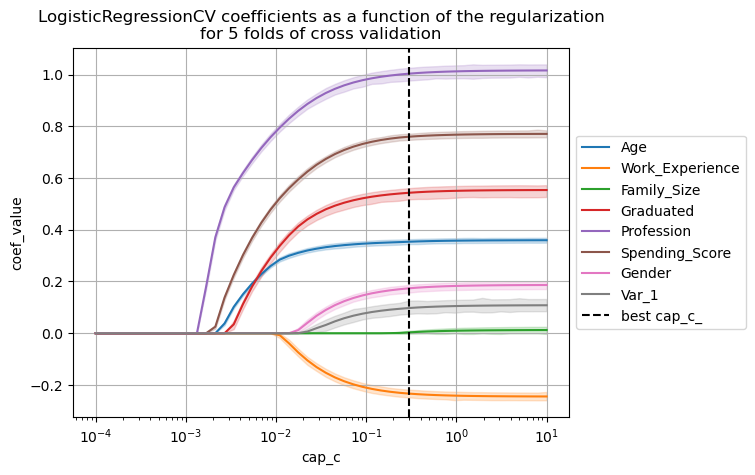


coef_:
[ 0.35303873 -0.2361912   0.          0.54352421  1.004252    0.76228804
  0.17573721  0.09882559]

scikit-learn model specific cv LogisticRegressionCV was fitted with penalty l1 with the following results

best regularization parameters:
   best C: 0.29470517025518095
   best l1_ratio: None

the model coefficients at the best regularization hyperparameters are:
   attribute Age coefficient: 0.3530387286366091
   attribute Work_Experience coefficient: -0.2361911974263982
   attribute Family_Size coefficient: 0.0
   attribute Graduated coefficient: 0.5435242078079718
   attribute Profession coefficient: 1.004252001302225
   attribute Spending_Score coefficient: 0.7622880393931438
   attribute Gender coefficient: 0.17573720870580395
   attribute Var_1 coefficient: 0.09882559420995714

number of attributes with zero coefficient: 1

the model cv average_precision_score is 0.8557197317334684

the model cv roc_auc_score is 0.8791039314867133

the mean test error estimate of log_loss 

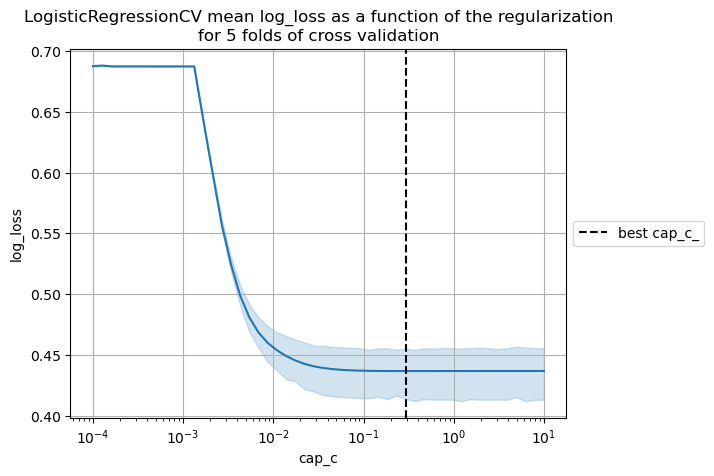




next we consider trading off log_loss to get simpler model - the plot above shows the trade space

the minimum mean log_loss from LogisticRegressionCV is located at cap_c 0.29470517025518095

at that cap_c the minimum mean log_loss from cv is 0.4370215367090253

at that cap_c the standard deviation of the log_loss from cv is 0.027263390497210792

consider trading 1.0 standard deviations of log_loss to move towards more regulation
and more zero coefficients

this means moving to a new cap_c 0.008685113737513529 where the log_loss is 0.4642849272062361
   - the log_loss has increased by 0.06238454677203493%

the model cv average_precision_score is 0.8522418902360418
   - this is a change of -0.0034778414974265814

the model cv roc_auc_score is 0.8769623969017027
   - this is a change of -0.0021415345850105405

the plots below show the original cap_c from LogisticRegressionCV and the new cap_c
for both the coefficient paths and the mean log_loss path






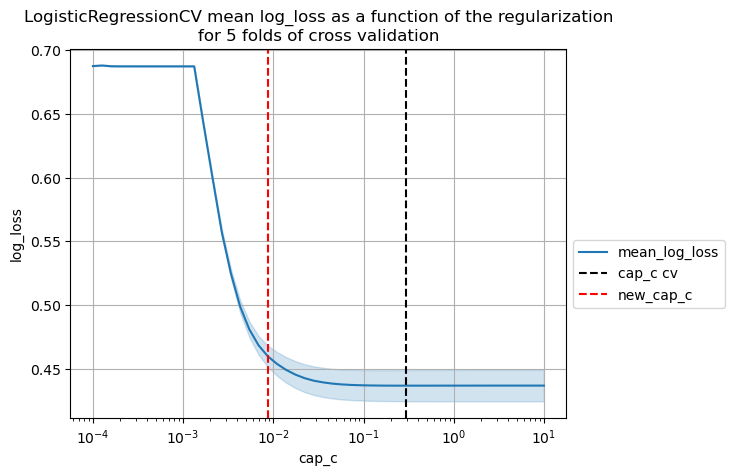

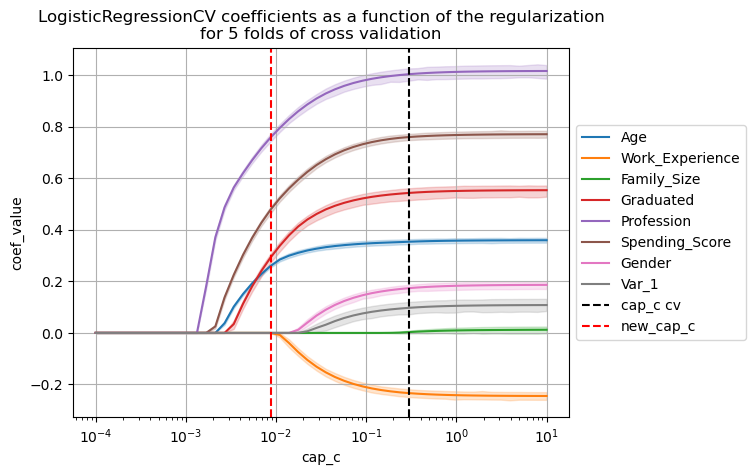





by shifting from the best cap_c = 0.29470517025518095 given by LogisticRegressionCV to a new cap_c = 0.008685113737513529
we have increased the number of zero coefficients from 1 to 4 giving us a simpler model

the cost of the simpler model is a 0.06238454677203493% increase in log_loss

the model cv average_precision_score is 0.8522418902360418
   - this is a change of -0.0034778414974265814

the model cv roc_auc_score is 0.8769623969017027
   - this is a change of -0.0021415345850105405


the original model coefficients were:

   attribute Age coefficient: 0.3530387286366091
   attribute Work_Experience coefficient: -0.2361911974263982
   attribute Family_Size coefficient: 0.0
   attribute Graduated coefficient: 0.5435242078079718
   attribute Profession coefficient: 1.004252001302225
   attribute Spending_Score coefficient: 0.7622880393931438
   attribute Gender coefficient: 0.17573720870580395
   attribute Var_1 coefficient: 0.09882559420995714

the new model coefficients are:


In [23]:
return_dict = class_utils.model_specific_cv(
    
    cap_x_df=train_cap_x_df,
    y_df=train_y_df,
    nominal_attr=nominal_attr, 
    numerical_attr=numerical_attr, 
    
    model_type=model_type,
    
    te_random_state=target_encoder_random_state, 
    
    cap_c_s=cap_c_s, 
    cv_folds=cv_folds, 
    penalty=penalty, 
    scoring=scoring, 
    solver=solver, 
    max_iter=max_iter, 
    class_weight=class_weight, 
    l1_ratio_list=l1_ratio_list,
    
    num_std=num_std
)

preproc_cap_x_df = return_dict['preproc_cap_x_df']
model_type = return_dict['model_type']
fitted_model_cv = return_dict['fitted_model_cv']
fitted_coef_dict = return_dict['fitted_coef_dict']
new_fitted_coef_dict = return_dict['new_fitted_coef_dict']

### Inspect Multicollinearity 

In [24]:
a_num_attr_list = nominal_attr + numerical_attr
vifs_df = mc_utils.print_vifs(preproc_cap_x_df, a_num_attr_list, vif_inspection_threshold=2, ols_large_vifs=True)


****************************************
investigate multi co-linearity - calculate variance inflation factors:

Added a bias term to the data frame to construct the design matrix for assessment of vifs.
scale the attributes - but not the bias term

         attribute   vif
0            const  1.00
4           Gender  1.02
5            Var_1  1.06
7  Work_Experience  1.06
1        Graduated  1.22
3   Spending_Score  1.25
8      Family_Size  1.29
2       Profession  1.45
6              Age  1.54


         attribute   vif
0            const  1.00
4           Gender  1.02
5            Var_1  1.06
7  Work_Experience  1.06
1        Graduated  1.22
3   Spending_Score  1.25
8      Family_Size  1.29
2       Profession  1.45
6              Age  1.54


[-0.32 -0.27 -0.27 -0.19 -0.16 -0.07 -0.06 -0.05 -0.03 -0.02 -0.02 -0.02
 -0.01  0.01  0.04  0.04  0.05  0.08  0.08  0.09  0.11  0.11  0.17  0.27
  0.31  0.33  0.36  0.46]

0.46

-0.32



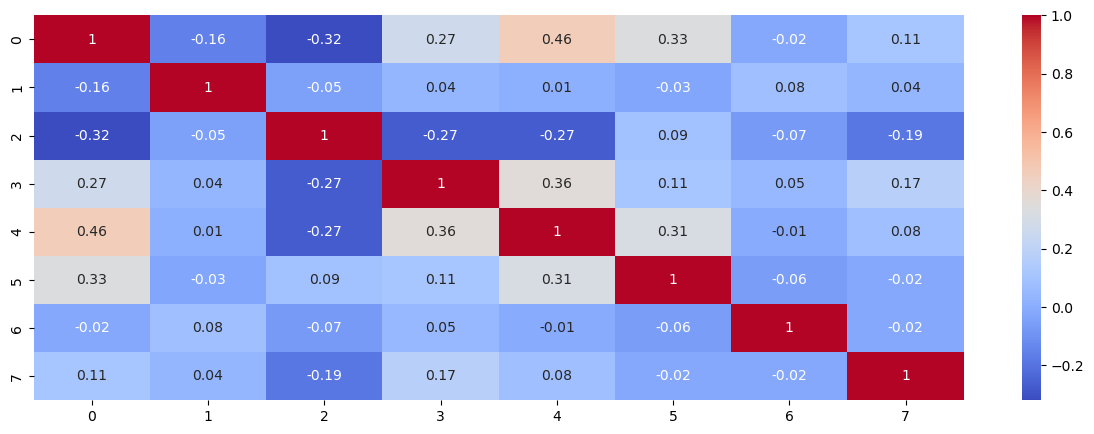

In [25]:
print(vifs_df)

correlation_matrix = preproc_cap_x_df.corr().round(2).values

triu_correlation_matrix = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k = 1)]

print()
flattened_corr_matrix = np.sort(triu_correlation_matrix.flatten())
print()
print(flattened_corr_matrix)
print()
print(flattened_corr_matrix.max())
print()
print(flattened_corr_matrix.min())

print()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

### Temporarily Remove High Vif Attributes & Inspect

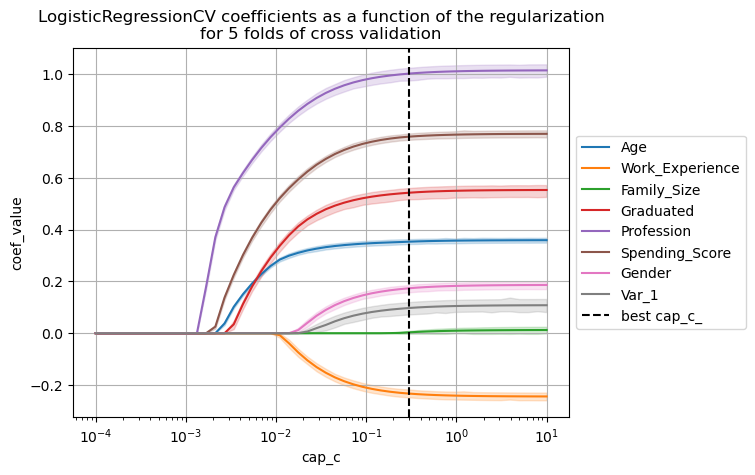


coef_:
[ 0.35303873 -0.2361912   0.          0.54352421  1.004252    0.76228804
  0.17573721  0.09882559]

scikit-learn model specific cv LogisticRegressionCV was fitted with penalty l1 with the following results

best regularization parameters:
   best C: 0.29470517025518095
   best l1_ratio: None

the model coefficients at the best regularization hyperparameters are:
   attribute Age coefficient: 0.3530387286366091
   attribute Work_Experience coefficient: -0.2361911974263982
   attribute Family_Size coefficient: 0.0
   attribute Graduated coefficient: 0.5435242078079718
   attribute Profession coefficient: 1.004252001302225
   attribute Spending_Score coefficient: 0.7622880393931438
   attribute Gender coefficient: 0.17573720870580395
   attribute Var_1 coefficient: 0.09882559420995714

number of attributes with zero coefficient: 1

the model cv average_precision_score is 0.8557197317334684

the model cv roc_auc_score is 0.8791039314867133

the mean test error estimate of log_loss 

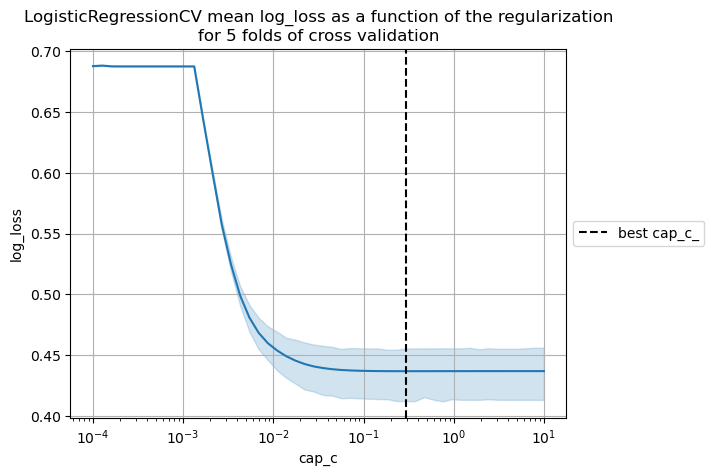




next we consider trading off log_loss to get simpler model - the plot above shows the trade space

the minimum mean log_loss from LogisticRegressionCV is located at cap_c 0.29470517025518095

at that cap_c the minimum mean log_loss from cv is 0.4370215367090253

at that cap_c the standard deviation of the log_loss from cv is 0.027263390497210792

consider trading 1.0 standard deviations of log_loss to move towards more regulation
and more zero coefficients

this means moving to a new cap_c 0.008685113737513529 where the log_loss is 0.4642849272062361
   - the log_loss has increased by 0.06238454677203493%

the model cv average_precision_score is 0.8522418902360418
   - this is a change of -0.0034778414974265814

the model cv roc_auc_score is 0.8769623969017027
   - this is a change of -0.0021415345850105405

the plots below show the original cap_c from LogisticRegressionCV and the new cap_c
for both the coefficient paths and the mean log_loss path






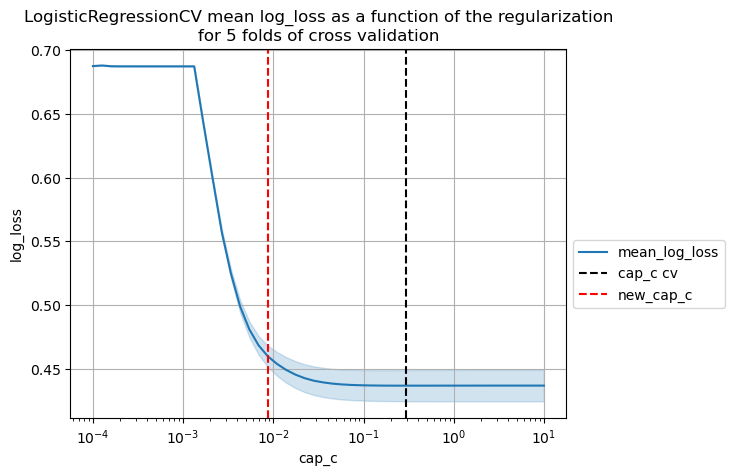

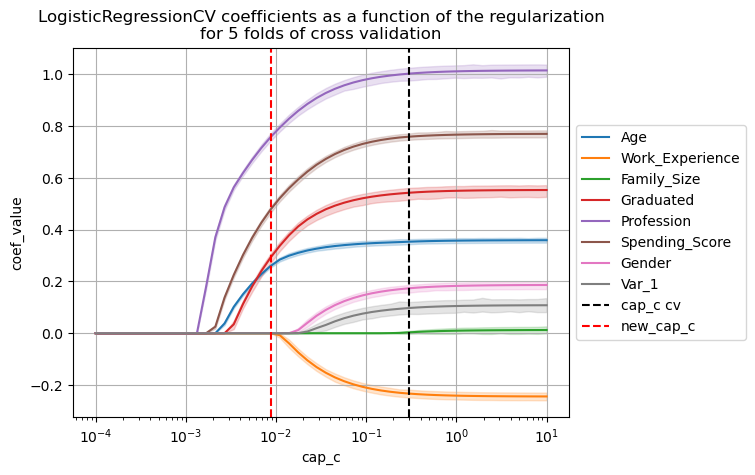





by shifting from the best cap_c = 0.29470517025518095 given by LogisticRegressionCV to a new cap_c = 0.008685113737513529
we have increased the number of zero coefficients from 1 to 4 giving us a simpler model

the cost of the simpler model is a 0.06238454677203493% increase in log_loss

the model cv average_precision_score is 0.8522418902360418
   - this is a change of -0.0034778414974265814

the model cv roc_auc_score is 0.8769623969017027
   - this is a change of -0.0021415345850105405


the original model coefficients were:

   attribute Age coefficient: 0.3530387286366091
   attribute Work_Experience coefficient: -0.2361911974263982
   attribute Family_Size coefficient: 0.0
   attribute Graduated coefficient: 0.5435242078079718
   attribute Profession coefficient: 1.004252001302225
   attribute Spending_Score coefficient: 0.7622880393931438
   attribute Gender coefficient: 0.17573720870580395
   attribute Var_1 coefficient: 0.09882559420995714

the new model coefficients are:


In [26]:
temp_numerical_attr = numerical_attr.copy()

# Put the attributes to remove her
#temp_numerical_attr.remove('Ever_Married') 
# temp_numerical_attr.remove('attr_14') 

return_dict = class_utils.model_specific_cv(
    
    cap_x_df=train_cap_x_df,
    y_df=train_y_df,
    nominal_attr=nominal_attr, 
    numerical_attr=temp_numerical_attr, 
    
    model_type=model_type,
    
    te_random_state=target_encoder_random_state, 
    
    cap_c_s=cap_c_s, 
    cv_folds=cv_folds, 
    penalty=penalty, 
    scoring=scoring, 
    solver=solver, 
    max_iter=max_iter, 
    class_weight=class_weight, 
    l1_ratio_list=l1_ratio_list,
    
    num_std=num_std
)

## check out script run time

In [27]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')

script run time: 0.32307159900665283 minutes
